(160, 320, 3)

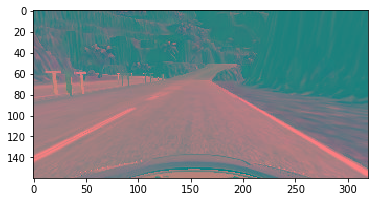

In [2]:
from matplotlib.pyplot import imshow
import cv2

image = cv2.imread('./data/IMG/center_2020_04_12_20_24_52_876.jpg  ')  
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)  
# Using cv2.imshow() method  
# Displaying the image  
imshow(image)  
image.shape

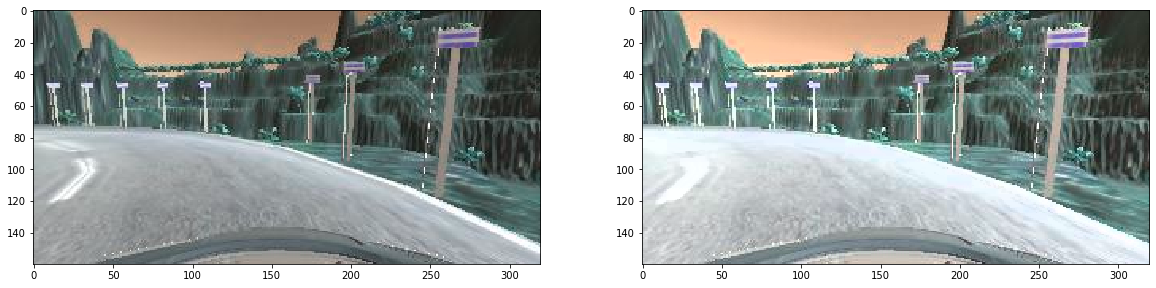

In [20]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2

def augment_brightness(img):
    # convert image to hsv for easier brightness modification
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  

    brightness = np.random.uniform(0.5, 1.5)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness, 0, 255)

    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return img

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
image = cv2.imread('./data/IMG/center_2020_04_15_22_51_51_114.jpg')
plt.imshow(image)

plt.subplot(1, 2, 2)
bright = augment_brightness(image)

plt.imshow(bright)

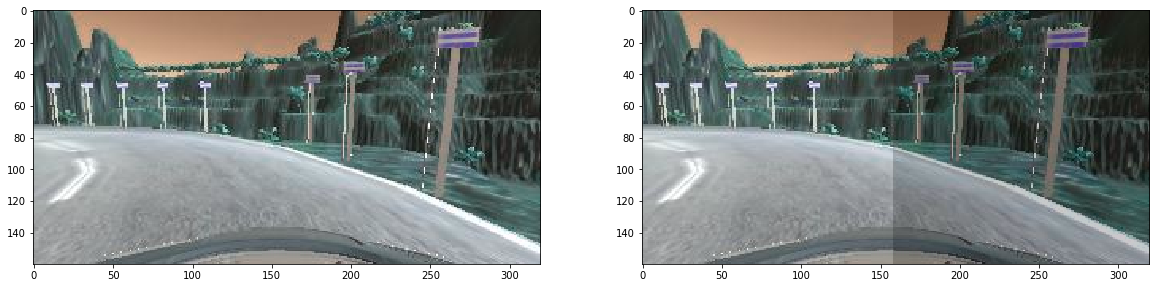

In [18]:
def add_random_shadow(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] = (new_img[:,0:mid,0] * factor).astype('uint8')
    else:
        new_img[:,mid:w,0] = (new_img[:,mid:w,0] * factor).astype('uint8')
    new_img = cv2.cvtColor(new_img, cv2.COLOR_YUV2BGR)
    return new_img


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
image = cv2.imread('./data/IMG/center_2020_04_15_22_51_51_114.jpg')
plt.imshow(image)

plt.subplot(1, 2, 2)
shadow = add_random_shadow(image)
plt.imshow(shadow)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_9 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 4, 33, 64)         36928     
__________

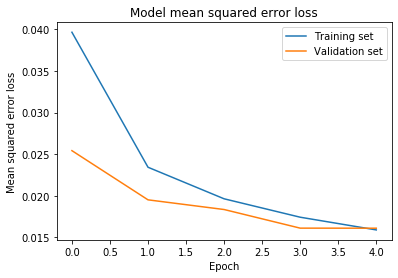

In [27]:
# importing os module  
# for reading files
import os 
import csv
import cv2
import sklearn
import random
import numpy as np #matrix math
import matplotlib.pyplot as plt
from keras.models import load_model
#The Sequential container is a linear stack of layers
from keras.models import Sequential
#to save our model periodically as checkpoints for loading later
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from sklearn.model_selection import train_test_split #to split out training and testing data 
from random import shuffle


samples = []

with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    header = next(reader) # pass the first line
    for line in reader:
        samples.append(line)



train_samples, validation_samples = train_test_split(samples, test_size=0.2)

############################################################################
###                         Image augmentation                           ###
############################################################################
"""
def add_random_shadow(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] = (new_img[:,0:mid,0] * factor).astype('uint8')
    else:
        new_img[:,mid:w,0] = (new_img[:,mid:w,0] * factor).astype('uint8')
    new_img = cv2.cvtColor(new_img, cv2.COLOR_YUV2BGR)
    return new_img

def augment_brightness(img):
    # convert image to hsv for easier brightness modification
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
    brightness = np.random.uniform(0.5, 1.5)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness, 0, 255)
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img

def augment_img(img):
    aug_img = augment_brightness(img)
    aug_img = add_random_shadow(aug_img)
    return aug_img
"""    
###########################################################################

def path(path):
    filename = os.path.normpath(path).split('\\')[-1]
    current_path =  './data/IMG/' + filename
    return current_path

def process_image(path):
    img = cv2.imread(path)
    #img_aug = augment_img(img)
    #img = cv2.cvtColor(img_aug, cv2.COLOR_BGR2YUV)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img




def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
     
            car_images = []
            steering_angles = []
            
            for batch_sample in batch_samples:

                # read in images from center, left and right cameras 
                img_center  = process_image(path(batch_sample[0]))
                img_left = process_image(path(batch_sample[1]))
                img_right = process_image(path(batch_sample[2]))
                
                
                steering_center = float(batch_sample[3])
                # create adjusted steering measurements for the side camera images
                correction = 0.2 # parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                

                
                # add images and steering angles to data set
                car_images.extend([img_center, img_left, img_right])
                steering_angles.extend([steering_center, steering_left, steering_right])

            augmented_images = []
            augmented_angles = []
            for (image, angle) in zip(car_images, steering_angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image, 1))
                augmented_angles.append(angle * -1.0)

            
            
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

            
            

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)


# create model
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x/127.5 - 1.))
model.add(Convolution2D(24, (5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(36, (5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(48, (5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))


checkpoint = ModelCheckpoint(filepath='model-{epoch:03d}.h5', monitor='val_loss', save_best_only=True)
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=5)

# Compile model
model.compile(loss='mse', optimizer='adam')

model.summary()

# Fit the model
history_object = model.fit_generator(train_generator, 
                steps_per_epoch=len(train_samples)/batch_size, 
                validation_data=validation_generator, 
                validation_steps=len(validation_samples),
                epochs = 5,
                callbacks=[checkpoint, stopper],                     
                verbose = 1)

# Save the model
model.save('model.h5')

### print the keys contained in the history object
print(history_object.history.keys())



# summarize history for loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model mean squared error loss')
plt.ylabel('Mean squared error loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.savefig('model.png')
plt.show()
                       

In [ ]:
Epoch 1/5
292/291 [==============================] - 2401s 8s/step - loss: 0.0456 - val_loss: 0.0243
Epoch 2/5
292/291 [==============================] - 2401s 8s/step - loss: 0.0246 - val_loss: 0.0190
Epoch 3/5
292/291 [==============================] - 2663s 9s/step - loss: 0.0204 - val_loss: 0.0193
Epoch 4/5
292/291 [==============================] - 2569s 9s/step - loss: 0.0181 - val_loss: 0.0153
Epoch 5/5
292/291 [==============================] - 2545s 9s/step - loss: 0.0155 - val_loss: 0.0163